In [57]:
# this is a comprehensive exploratory data analysis notebook for my data set
# requirements info(), .describe, missing counts
# bivariate  visuals: scatterplot/line for at least 2 relationships
# correlation heatmap
# clear markdown documenting findings

## 0) Importing datasets

In [58]:
#load dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
%matplotlib inline
# !pip install pandas numpy matplotlib seaborn --- IGNORE ---  
sns.set(context='talk', style='whitegrid')
np.random.seed(8)
pd.set_option('display.max_columns', 100)

# Helper display
def title(msg):
    print('\n' + '='*len(msg))
    print(msg)
    print('='*len(msg))

## 1. Synthetic Data Generator (Reproducible)
No external CSVs required. This mimics a small financial-behavior dataset with both numeric and categorical variables and a time component.

In [59]:
n = 360 
df = pd.DataFrame({
    'dates': pd.date_range('2021-01-01', periods=n, freq='D'),
    'customer_id': range(1, n+1),
    'age': np.random.randint(18, 70, n),
    'income': np.random.normal(60000, 15000, n).astype(int),
    'account_balance': np.random.normal(15000, 5000, n).astype(int),
    'num_transactions': np.random.poisson(30, n),
    'account_type': np.random.choice(['savings', 'checking', 'credit'], n, p=[0.5, 0.4, 0.1]),
    'region': np.random.choice(['north', 'south', 'east', 'west'], n),
    'tenure_years': np.random.randint(1, 20, n),
    'churned': np.random.choice([0,1], n, p=[0.85,0.15]),
    'last_login_days_ago': np.random.randint(0, 60, n),
    'credit_score': np.random.normal(700, 50, n).astype(int),
    'default_flag': np.random.choice([0,1], n, p=[0.8,0.2])
})
# Inject missingness and outliers
mask = np.random.rand(n) < 0.1
df.loc[mask, 'income'] = np.nan
df.loc[np.random.choice(n, 5), 'account_balance'] *= 3  # outliers  


df.head()   


dates  customer_id  age   income  account_balance  num_transactions  \
0 2021-01-01            1   21  54184.0            16178                30   
1 2021-01-02            2   38  55133.0            14622                38   
2 2021-01-03            3   67  71818.0            13620                24   
3 2021-01-04            4   59  34782.0            10255                41   
4 2021-01-05            5   23  92185.0            17773                33   

  account_type region  tenure_years  churned  last_login_days_ago  \
0      savings  north             1        0                   28   
1      savings   east             3        0                    7   
2      savings  south             7        0                   45   
3      savings   west             3        0                   13   
4      savings  north            18        0                   34   

   credit_score  default_flag  
0           659             1  
1           629             1  
2           761             0  
3           737             0  
4           640             0

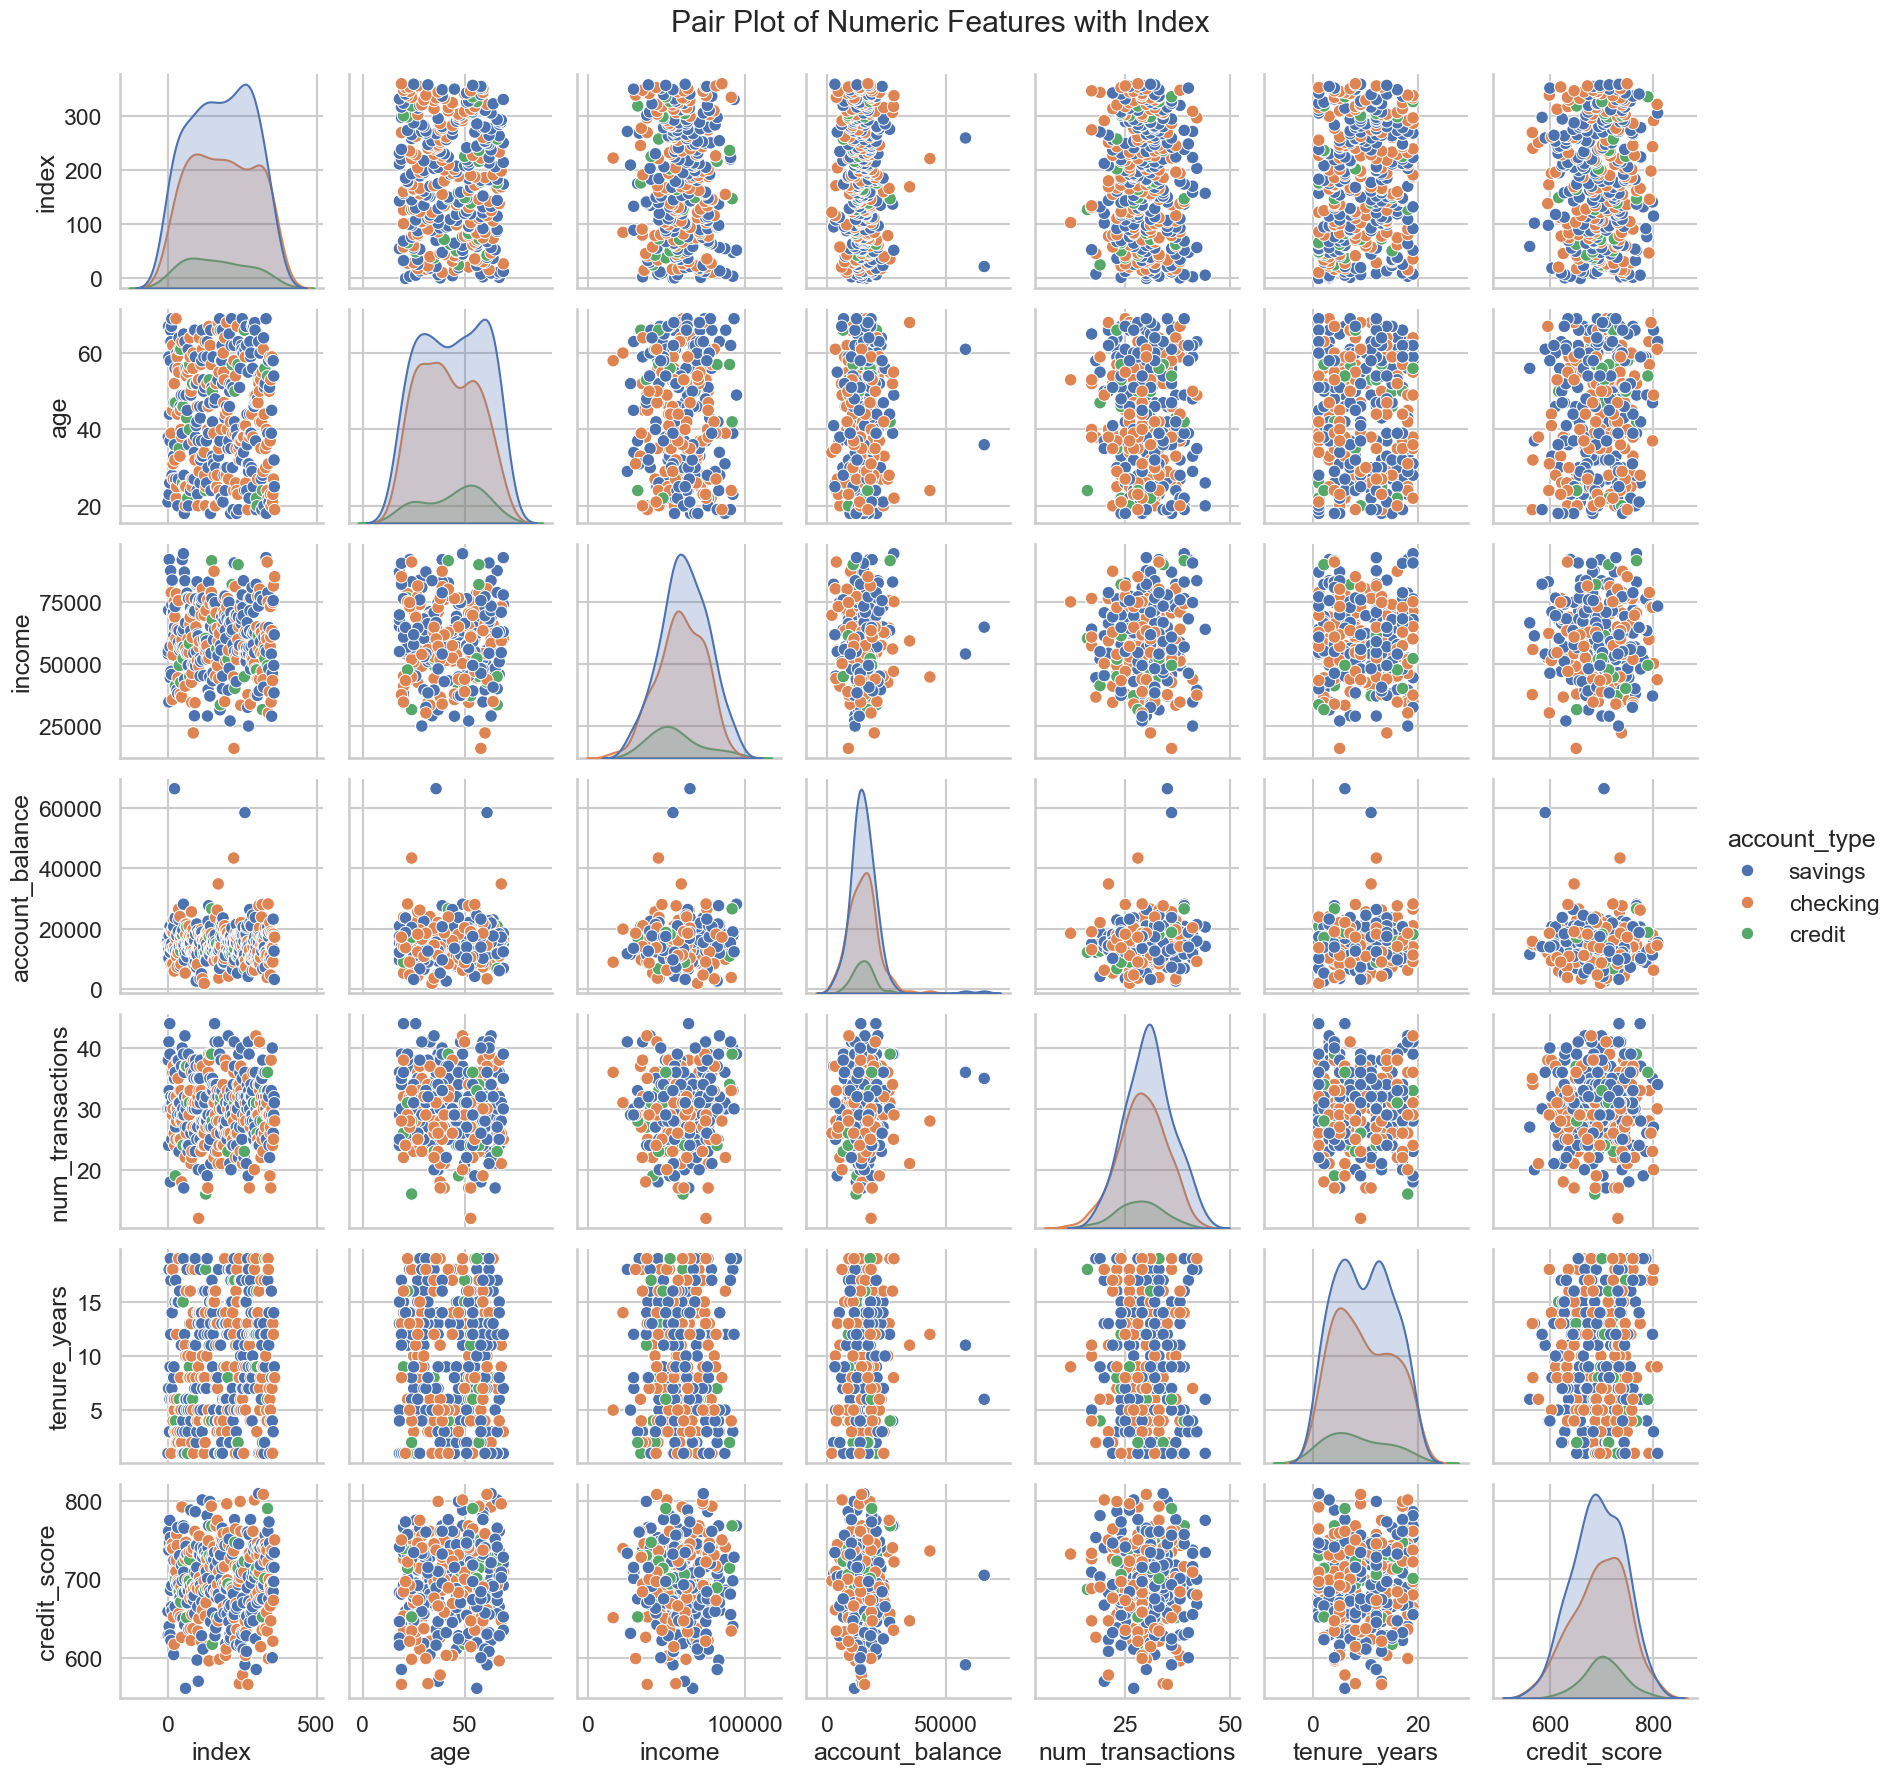

In [60]:
# --- Pair Plot Including Index for Time Context ---

# Temporarily add numeric index for plotting
df['index'] = range(len(df))
sns.pairplot(df, hue='account_type', diag_kind='kde', vars=['index', 'age', 'income', 'account_balance', 'num_transactions', 'tenure_years', 'credit_score'])
plt.suptitle('Pair Plot of Numeric Features with Index', y=1.02)
plt.show()  
# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('customer_id')  # Exclude ID column
numeric_cols.remove('churned')      # Exclude target variable
numeric_cols.remove('default_flag') # Exclude target variable
numeric_cols.remove('index')       # Remove temporary index column

      


## 2. First Look: Structure & Sanity Checks

In [61]:
title("Data Overview")
df.info()
df.describe(include='all').T
display(df.head(5))
display (df.tail(5))
title("Missing Values")
df.isnull().sum()



Data Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   dates                360 non-null    datetime64[ns]
 1   customer_id          360 non-null    int64         
 2   age                  360 non-null    int64         
 3   income               317 non-null    float64       
 4   account_balance      360 non-null    int64         
 5   num_transactions     360 non-null    int64         
 6   account_type         360 non-null    object        
 7   region               360 non-null    object        
 8   tenure_years         360 non-null    int64         
 9   churned              360 non-null    int64         
 10  last_login_days_ago  360 non-null    int64         
 11  credit_score         360 non-null    int64         
 12  default_flag         360 non-null    int64         
 13  index               

dates  customer_id  age   income  account_balance  num_transactions  \
0 2021-01-01            1   21  54184.0            16178                30   
1 2021-01-02            2   38  55133.0            14622                38   
2 2021-01-03            3   67  71818.0            13620                24   
3 2021-01-04            4   59  34782.0            10255                41   
4 2021-01-05            5   23  92185.0            17773                33   

  account_type region  tenure_years  churned  last_login_days_ago  \
0      savings  north             1        0                   28   
1      savings   east             3        0                    7   
2      savings  south             7        0                   45   
3      savings   west             3        0                   13   
4      savings  north            18        0                   34   

   credit_score  default_flag  index  
0           659             1      0  
1           629             1      1  
2           761             0      2  
3           737             0      3  
4           640             0      4

dates  customer_id  age   income  account_balance  num_transactions  \
355 2021-12-22          356   27  81537.0            18188                25   
356 2021-12-23          357   54  49504.0            17431                29   
357 2021-12-24          358   32  38446.0            12594                32   
358 2021-12-25          359   25  61880.0             3246                31   
359 2021-12-26          360   19  85263.0            17192                28   

    account_type region  tenure_years  churned  last_login_days_ago  \
355     checking   east            12        0                   11   
356      savings  south            14        1                   34   
357      savings  south             8        0                   48   
358      savings  north             9        1                   29   
359     checking  north             8        0                   56   

     credit_score  default_flag  index  
355           673             0    355  
356           697             0    356  
357           715             0    357  
358           734             0    358  
359           750             0    359


Missing Values


dates                   0
customer_id             0
age                     0
income                 43
account_balance         0
num_transactions        0
account_type            0
region                  0
tenure_years            0
churned                 0
last_login_days_ago     0
credit_score            0
default_flag            0
index                   0
dtype: int64

In [62]:
title("Descripive Statistics")
desc = df.describe(include='all').T
desc['missing_pct'] = df.isnull().mean()
desc = desc[['count', 'missing_pct', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'unique', 'top', 'freq']]
desc['skew'] = df.skew(numeric_only=True)
desc['kurtosis'] = df.kurtosis(numeric_only=True)
desc



Descripive Statistics


count  missing_pct                 mean           std  \
dates                  360     0.000000  2021-06-29 12:00:00           NaN   
customer_id          360.0     0.000000                180.5    104.067286   
age                  360.0     0.000000            43.194444     14.898018   
income               317.0     0.119444         59987.025237  15017.997877   
account_balance      360.0     0.000000         15296.902778   6263.104792   
num_transactions     360.0     0.000000            29.836111      5.566846   
account_type           360     0.000000                  NaN           NaN   
region                 360     0.000000                  NaN           NaN   
tenure_years         360.0     0.000000             9.461111      5.384765   
churned              360.0     0.000000             0.166667      0.373197   
last_login_days_ago  360.0     0.000000               29.125      17.03604   
credit_score         360.0     0.000000           695.683333     49.608717   
default_flag         360.0     0.000000             0.216667      0.412547   
index                360.0     0.000000                179.5    104.067286   

                                     min                  25%  \
dates                2021-01-01 00:00:00  2021-03-31 18:00:00   
customer_id                          1.0                90.75   
age                                 18.0                 30.0   
income                           16049.0              50241.0   
account_balance                   1922.0              11740.0   
num_transactions                    12.0                 26.0   
account_type                         NaN                  NaN   
region                               NaN                  NaN   
tenure_years                         1.0                  5.0   
churned                              0.0                  0.0   
last_login_days_ago                  0.0                 15.0   
credit_score                       561.0                662.5   
default_flag                         0.0                  0.0   
index                                0.0                89.75   

                                     50%                  75%  \
dates                2021-06-29 12:00:00  2021-09-27 06:00:00   
customer_id                        180.5               270.25   
age                                 43.5                 56.0   
income                           59774.0              71182.0   
account_balance                  14852.5              18116.0   
num_transactions                    30.0                 33.0   
account_type                         NaN                  NaN   
region                               NaN                  NaN   
tenure_years                         9.0                 14.0   
churned                              0.0                  0.0   
last_login_days_ago                 29.0                 44.0   
credit_score                       696.5               733.25   
default_flag                         0.0                  0.0   
index                              179.5               269.25   

                                     max unique      top freq      skew  \
dates                2021-12-26 00:00:00    NaN      NaN  NaN       NaN   
customer_id                        360.0    NaN      NaN  NaN  0.000000   
age                                 69.0    NaN      NaN  NaN  0.007012   
income                           94541.0    NaN      NaN  NaN -0.084086   
account_balance                  66255.0    NaN      NaN  NaN  2.670961   
num_transactions                    44.0    NaN      NaN  NaN -0.064191   
account_type                         NaN      3  savings  194       NaN   
region                               NaN      4     west   99       NaN   
tenure_years                        19.0    NaN      NaN  NaN  0.147234   
churned                              1.0    NaN      NaN  NaN  1.796348   
last_login_days_ago                 59.0    NaN      NaN  NaN -0.027637  

## 3. Univariate Visuals: Distributions & Outliers

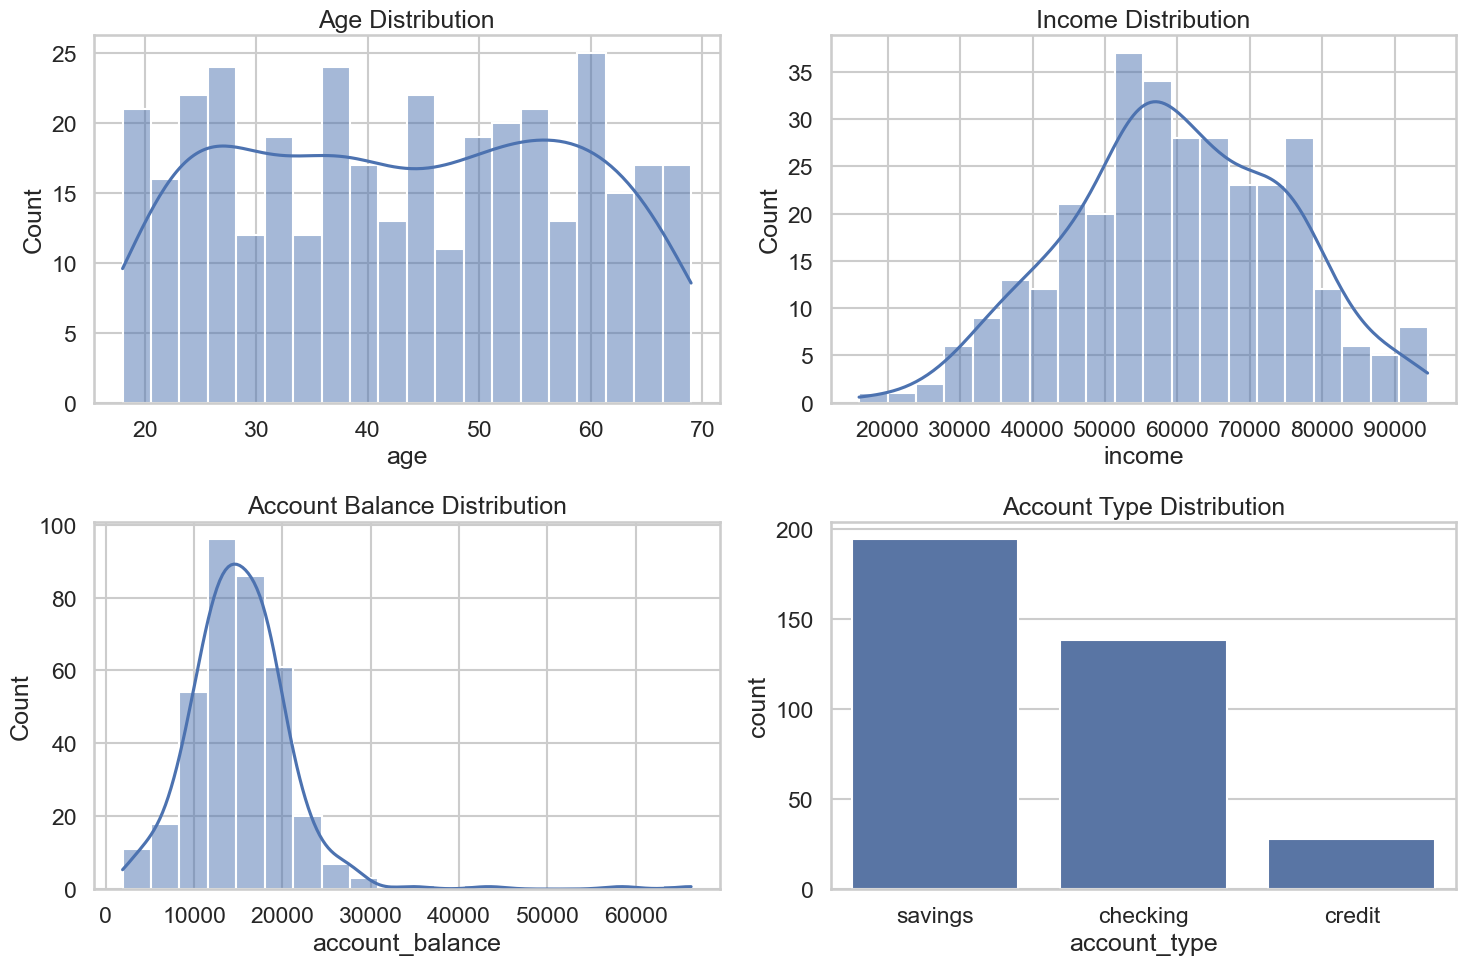

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df['age'], bins=20, kde=True, ax=axes[0,0])
axes[0,0].set_title('Age Distribution')
sns.histplot(df['income'].dropna(), bins=20, kde=True, ax=axes[0,1])
axes[0,1].set_title('Income Distribution')
sns.histplot(df['account_balance'], bins=20, kde=True, ax=axes[1,0])
axes[1,0].set_title('Account Balance Distribution')
sns.countplot(x='account_type', data=df, ax=axes[1,1])
axes[1,1].set_title('Account Type Distribution')
plt.tight_layout()
plt.show()



## 4. Bivariate Visuals: Relationships

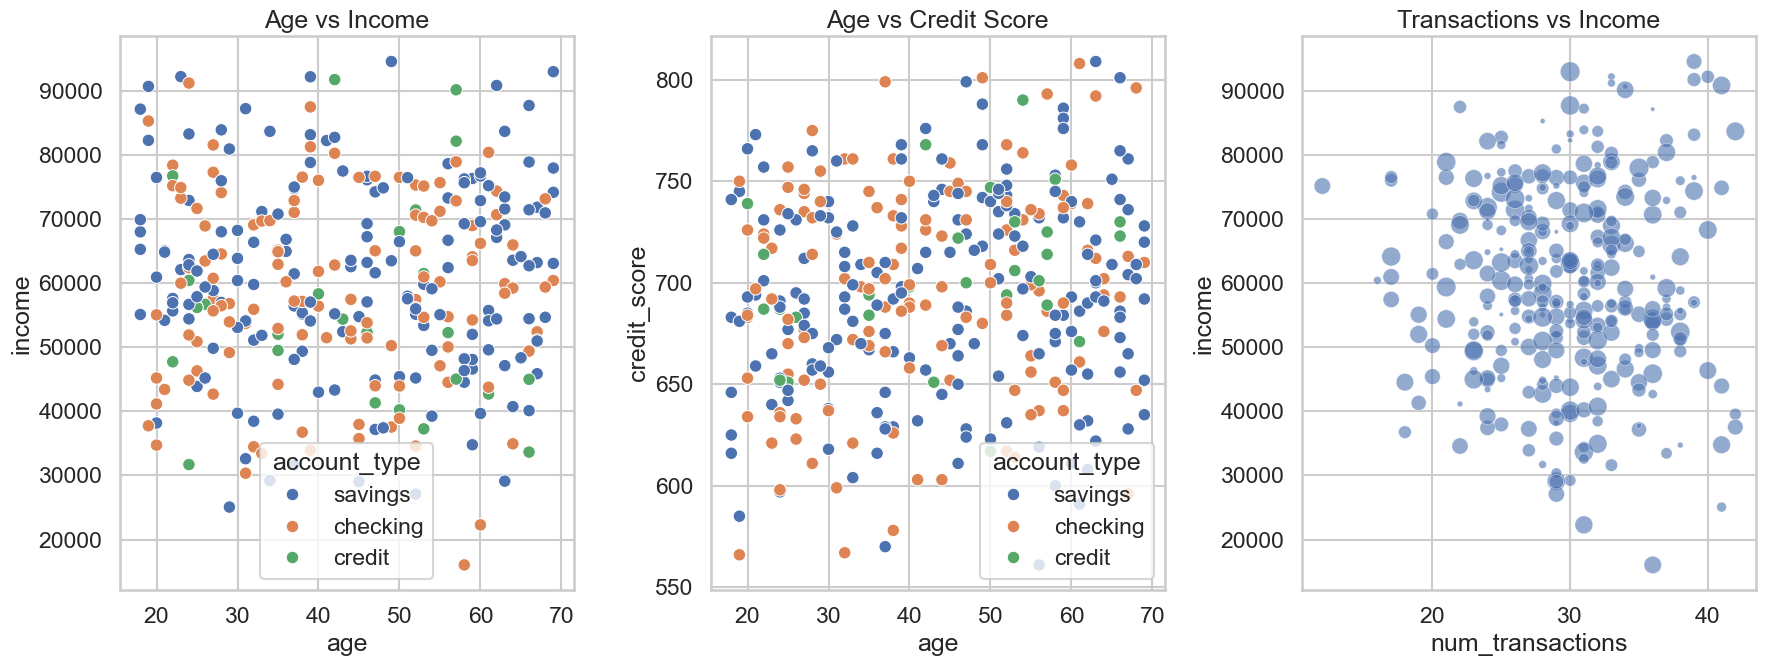

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered = df[df['num_transactions'] <= df['num_transactions'].quantile(0.99)]

fig, axes = plt.subplots(1, 3, figsize=(18, 7))

# 1) Age vs Income
sns.scatterplot(x='age', y='income', hue='account_type', data=df_filtered, ax=axes[0])
axes[0].set_title('Age vs Income')

# 2) Age vs Credit Score
sns.scatterplot(x='age', y='credit_score', hue='account_type', data=df_filtered, ax=axes[1])
axes[1].set_title('Age vs Credit Score')

# 3) Transactions vs Income (size by age, one color, transparency)
sns.scatterplot(
    x='num_transactions', y='income',
    data=df_filtered, ax=axes[2],
    size='age', sizes=(10, 200), alpha=0.6, legend=False
)
axes[2].set_title('Transactions vs Income')

plt.tight_layout()
plt.show()














## 5. Time Series Glance

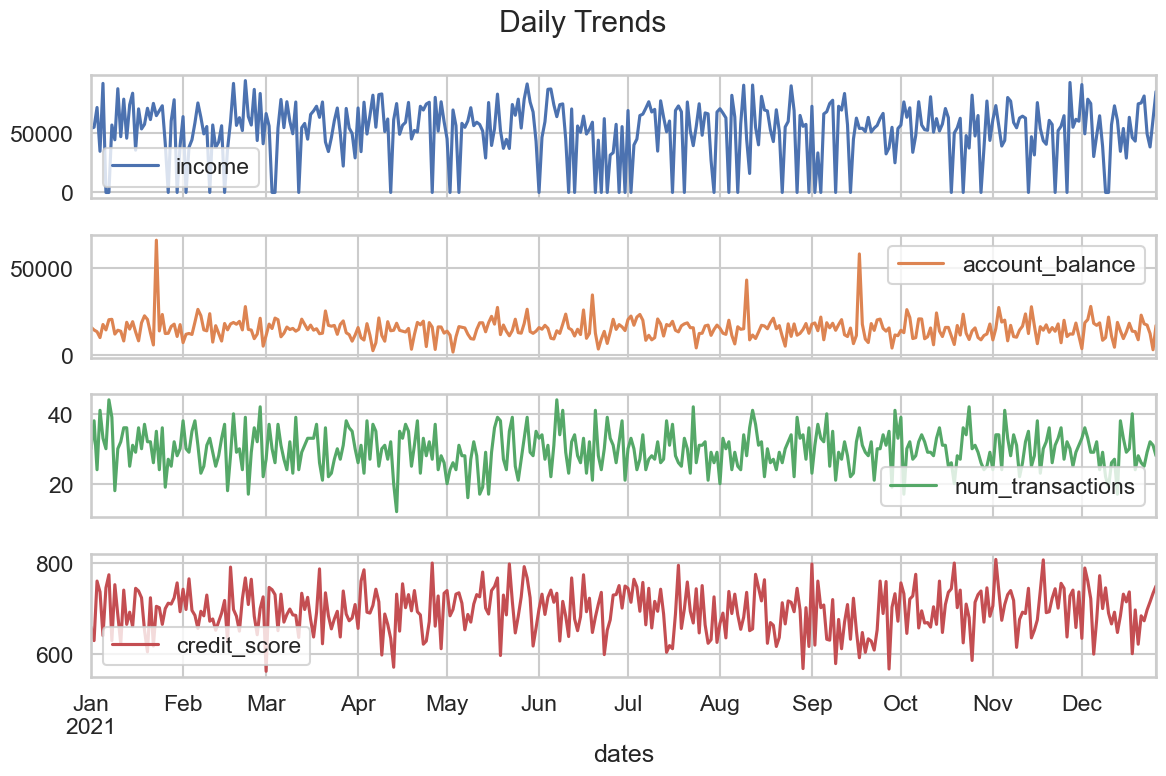

In [65]:
#d aily trends
daily = df.set_index('dates')[['income', 'account_balance', 'num_transactions', 'credit_score']].resample('D').sum()  
daily.plot(figsize=(12,8), subplots=True, layout=(4,1), title='Daily Trends')
plt.tight_layout()
plt.show() 

## 6. Multi-Granularity Time-Series Grid with Rolling & Cumulative

In [66]:
#setup (imports, constraints)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# !pip install matplotlib seaborn numpy pandas --- IGNORE ---  
np.random.seed(42)
date_range = pd.date_range(start='2021-01-01', end='2024-12-31', freq='D')
n_days = len(date_range)




In [67]:
## Generate Additive Data
def generate_additive_data():
    # Base trends
    spend_trend = np.linspace(100, 500, n_days)
    transactions_trend = np.linspace(50, 150, n_days)
    visits_trend = np.linspace(200, 300, n_days)

    # Seasonality (additive)
    seasonality = 30 * np.sin(2 * np.pi * date_range.dayofyear / 365.25)

    # Noise (additive)
    noise_spend = np.random.normal(0, 20, n_days)
    noise_transactions = np.random.normal(0, 10, n_days)
    noise_visits = np.random.normal(0, 15, n_days)

    # Construct additive data
    df_additive = pd.DataFrame({
        'date': date_range,
        'spend': spend_trend + seasonality + noise_spend,
        'transactions': transactions_trend + 0.5 * seasonality + noise_transactions,
        'visits': visits_trend + 0.3 * seasonality + noise_visits
    })
    return df_additive



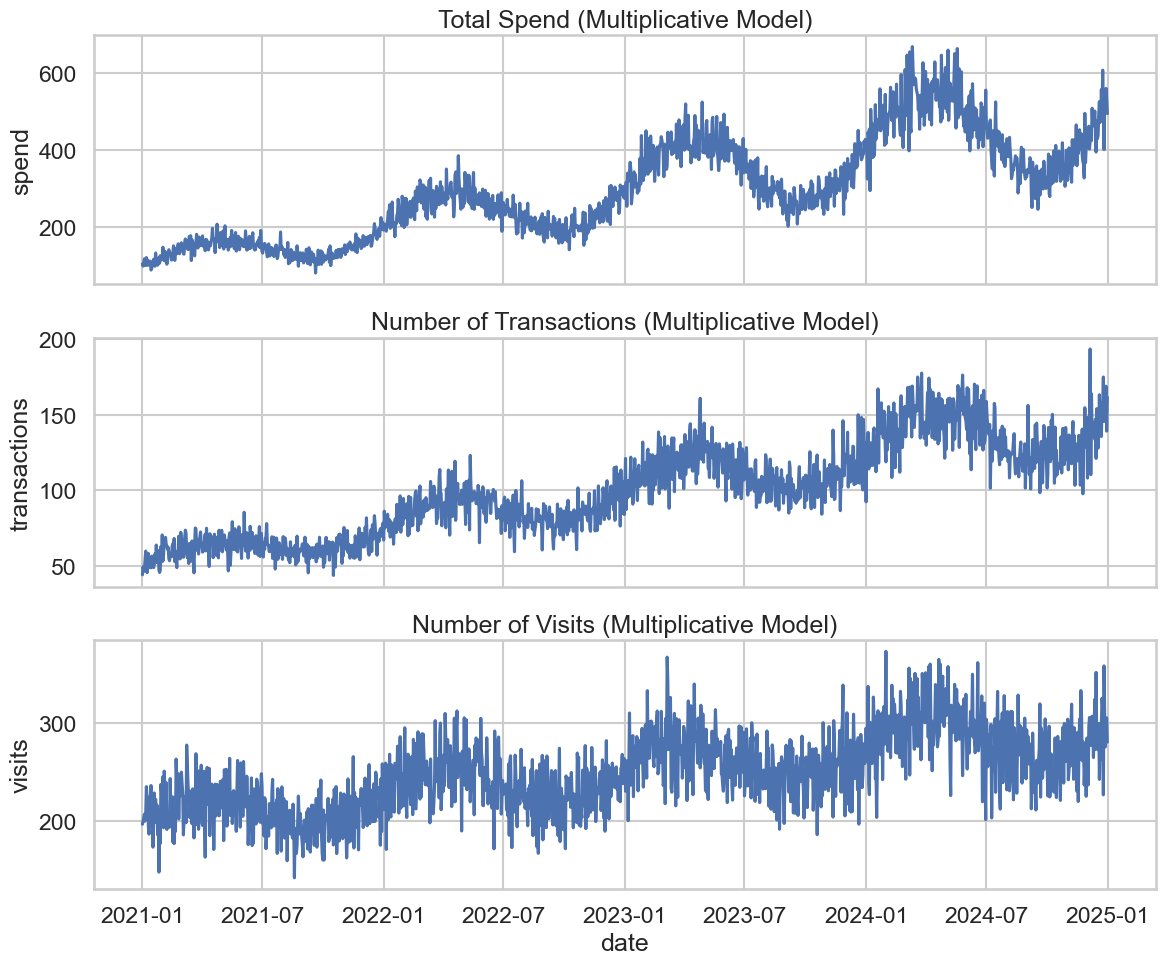

In [68]:
#Generate Multiplicative Data
def generate_multiplicative_data():
    
    spend_trend = np.linspace(100, 500, n_days)  # Linear trend
    transactions_trend = np.linspace(50, 150, n_days) 
    visits_trend = np.linspace(200, 300, n_days) 

  
    seasonality_spend = 1 + 0.3 * np.sin(2 * np.pi * date_range.dayofyear / 365.25)
    seasonality_transactions = 1 + 0.15 * np.sin(2 * np.pi * date_range.dayofyear / 365.25)
    seasonality_visits = 1 + 0.1 * np.sin(2 * np.pi * date_range.dayofyear / 365.25) # Seasonal component

    noise_spend = np.random.normal(1, 0.1, n_days)
    noise_transactions = np.random.normal(1, 0.1, n_days)
    noise_visits = np.random.normal(1, 0.1, n_days) # Random noise

    #construct dataframe
    df_multiplicative = pd.DataFrame({
        'date': date_range,
        'spend': spend_trend * seasonality_spend * noise_spend,
        'transactions': transactions_trend * seasonality_transactions * noise_transactions,
        'visits': visits_trend * seasonality_visits * noise_visits
    })
    return df_multiplicative
df_multiplicative = generate_multiplicative_data()
df_multiplicative.head()
df_multiplicative.tail()
df_multiplicative.describe().T
# Plot Multiplicative Data
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
sns.lineplot(x='date', y='spend', data=df_multiplicative, ax=axes[0])
axes[0].set_title('Total Spend (Multiplicative Model)')
sns.lineplot(x='date', y='transactions', data=df_multiplicative, ax=axes[1])
axes[1].set_title('Number of Transactions (Multiplicative Model)')
sns.lineplot(x='date', y='visits', data=df_multiplicative, ax=axes[2])
axes[2].set_title('Number of Visits (Multiplicative Model)')
plt.tight_layout()
plt.show()


## Time Series Simulation: Additive vs Multiplicative

We can simulate time series data with different components (Trend, Monthly, Quarterly, Yearly, Noise).  

- **Additive model**: Each component is added together. The total value at any time is the sum of its components.  
- **Multiplicative model**: Each component multiplies the base value. Growth and seasonal effects scale with the series level.  

Use the toggle below to switch between additive and multiplicative simulations for live exploration.

In [69]:
# Set this to either 'additive' or 'multiplicative' to pick your dataset
data_choice = 'additive'  
if data_choice == 'additive':
    df2 = generate_additive_data()
elif data_choice == 'multiplicative':
    df2 = generate_multiplicative_data()
else:
    raise ValueError("data_choice must be either 'additive' or 'multiplicative'")

print(f"Using {data_choice} with shape: {df2.shape}")




Using additive with shape: (1461, 4)


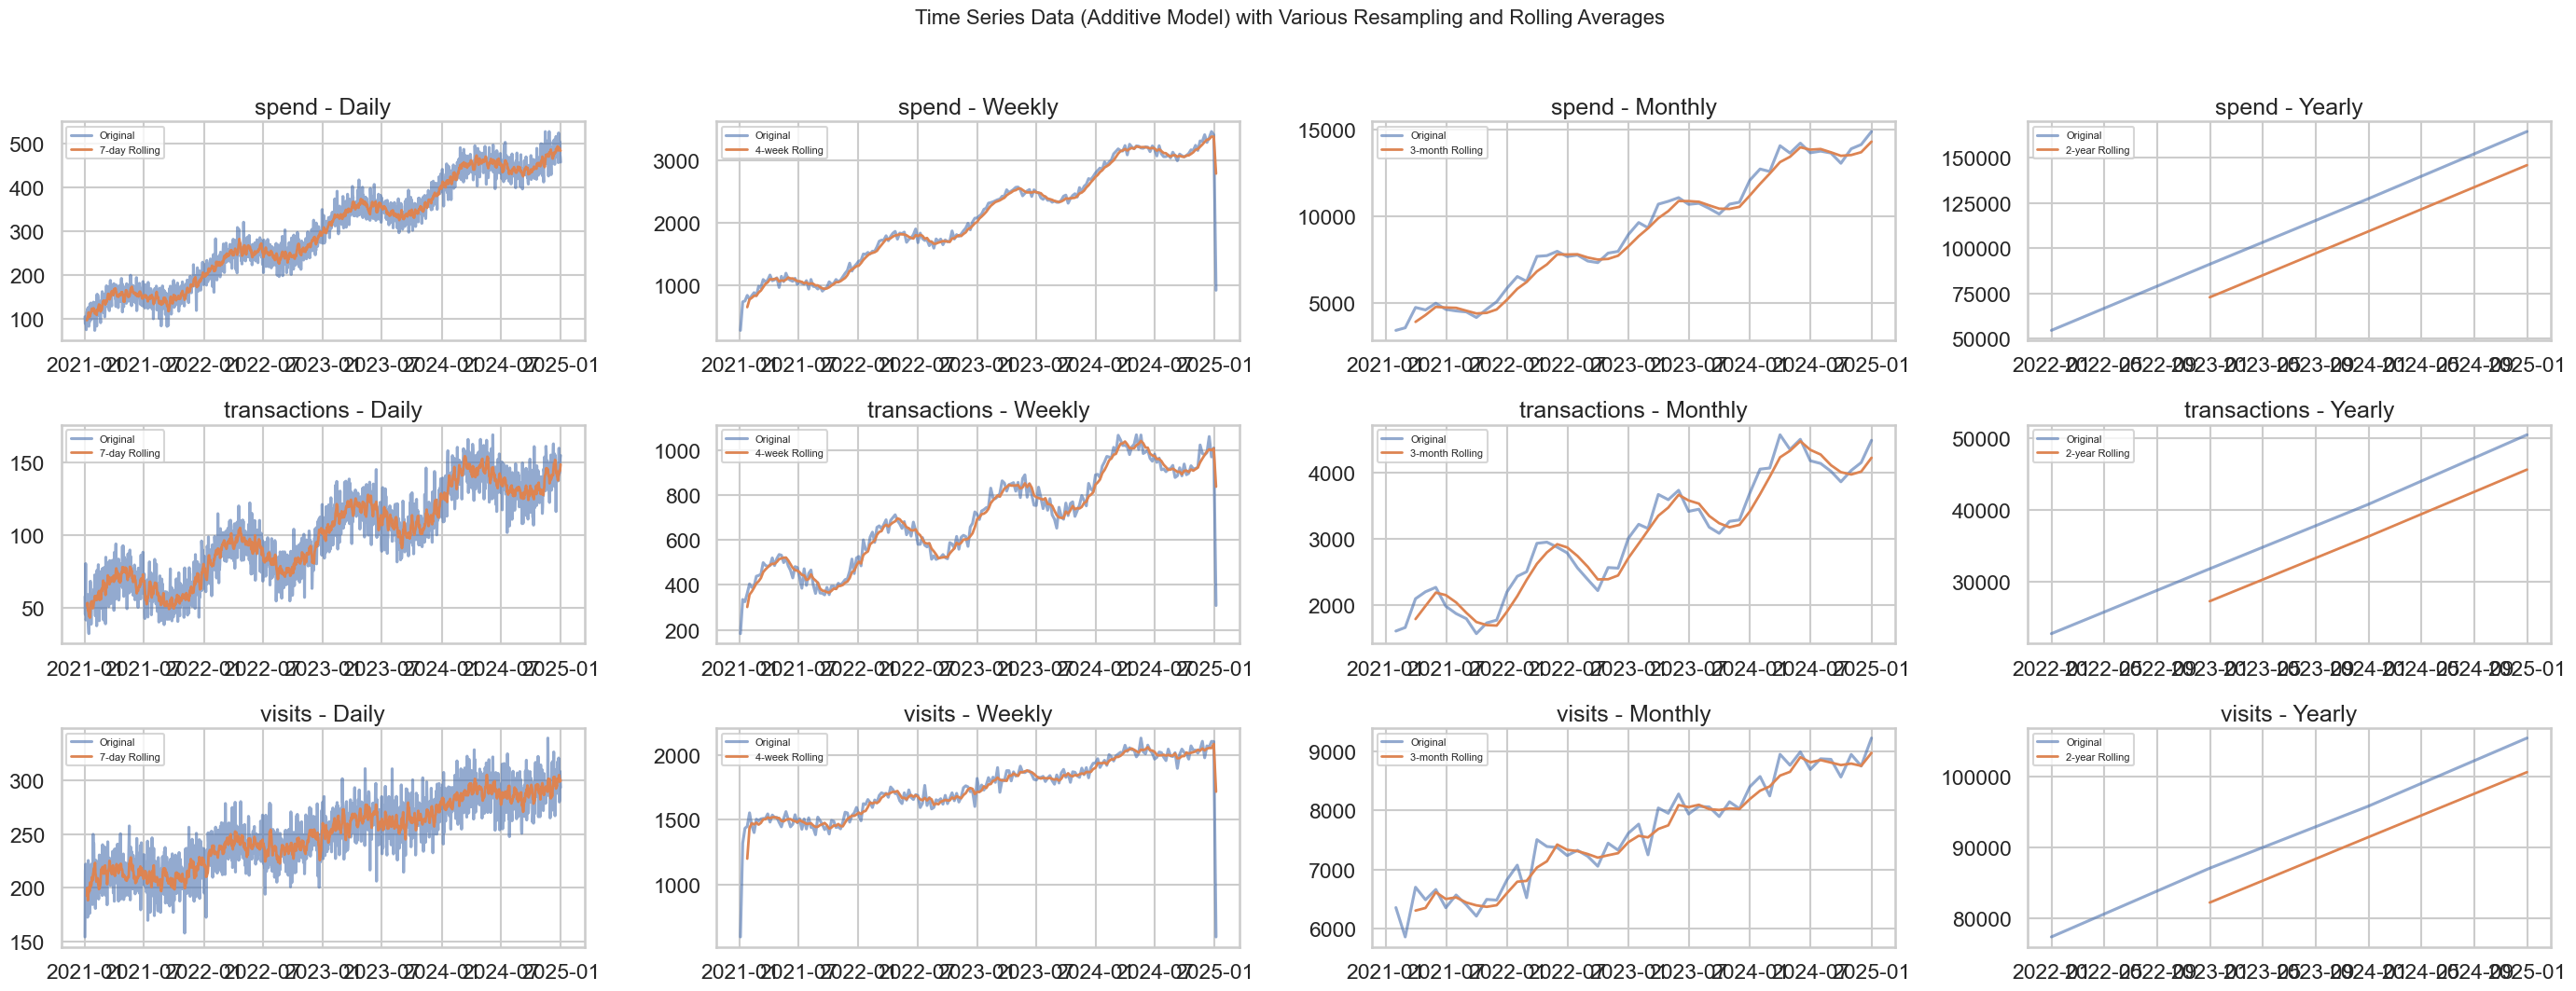

In [70]:
# Plotting Code
# Prepare data for plotting
ts_df = df2.copy()
ts_df['date'] = pd.to_datetime(ts_df['date'])
ts_df.set_index('date', inplace=True)

numeric_cols = ts_df.select_dtypes(include=np.number).columns.tolist()

daily = ts_df[numeric_cols].resample('D').sum()
weekly = ts_df[numeric_cols].resample('W').sum()
monthly = ts_df[numeric_cols].resample('ME').sum()   
yearly = ts_df[numeric_cols].resample('YE').sum()

daily_roll=daily.rolling(window=7).mean()
weekly_roll=weekly.rolling(window=4).mean()
monthly_roll=monthly.rolling(window=3).mean()
yearly_roll=yearly.rolling(window=2).mean()

fig, axes = plt.subplots(len(numeric_cols), 4, figsize=(28, 3.5 * len(numeric_cols)))

fig.suptitle(f'Time Series Data ({data_choice.capitalize()} Model) with Various Resampling and Rolling Averages', fontsize=16, y=1.02)

if len(numeric_cols) == 1:
    axes = axes.reshape(1, -1) # Ensure axes is 2D array for consistency  

for i, col in enumerate(numeric_cols):
    axes[i, 0].plot(daily.index, daily[col], label='Original', alpha=0.6)
    axes[i, 0].plot(daily_roll.index, daily_roll[col], label='7-day Rolling', linewidth=2)
    axes[i, 0].set_title(f'{col} - Daily')
    axes[i, 0].legend(loc='upper left', fontsize=8)

    axes[i, 1].plot(weekly.index, weekly[col], label='Original', alpha=0.6)
    axes[i, 1].plot(weekly_roll.index, weekly_roll[col], label='4-week Rolling', linewidth=2)
    axes[i, 1].set_title(f'{col} - Weekly')
    axes[i, 1].legend(loc='upper left', fontsize=8)

    axes[i, 2].plot(monthly.index, monthly[col], label='Original', alpha=0.6)
    axes[i, 2].plot(monthly_roll.index, monthly_roll[col], label='3-month Rolling', linewidth=2)
    axes[i, 2].set_title(f'{col} - Monthly')
    axes[i, 2].legend(loc='upper left', fontsize=8)

    axes[i, 3].plot(yearly.index, yearly[col], label='Original', alpha=0.6)
    axes[i, 3].plot(yearly_roll.index, yearly_roll[col], label='2-year Rolling', linewidth=2)
    axes[i, 3].set_title(f'{col} - Yearly')
    axes[i, 3].legend(loc='upper left', fontsize=8)  
plt.tight_layout()
plt.show()

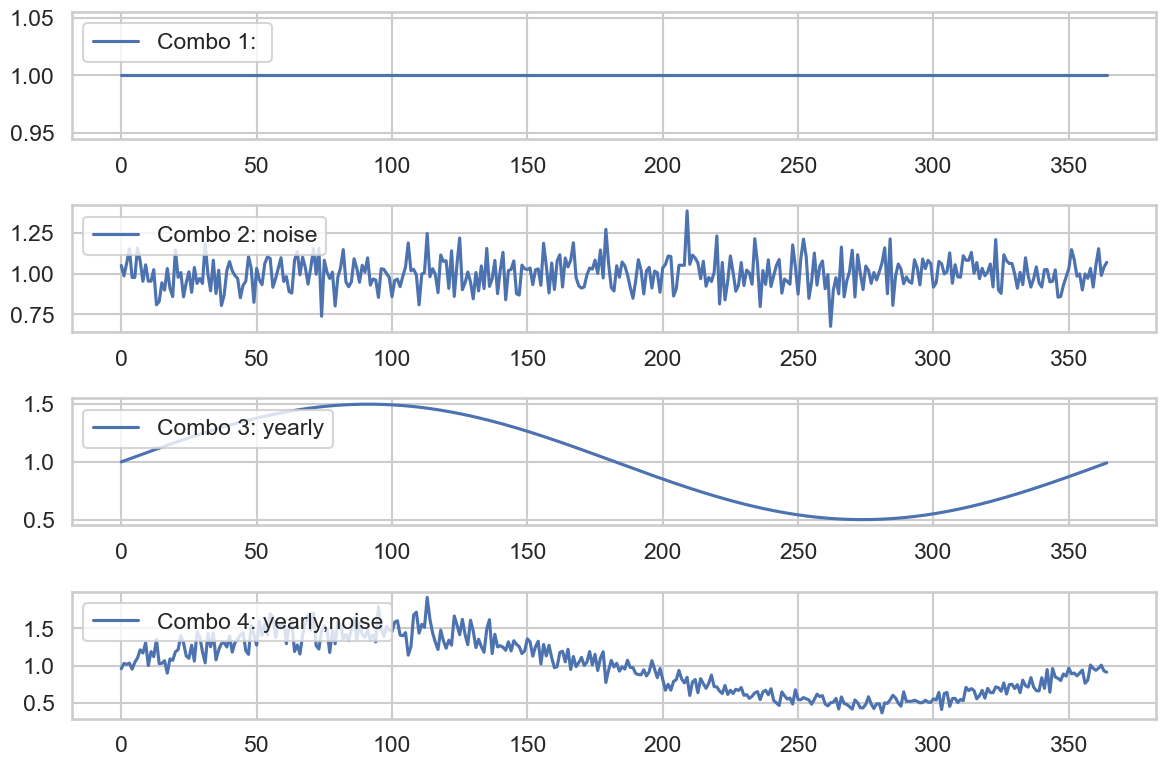

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

np.random.seed(42)
n_days = 365

# Component generators
def trend(t): return 0.05*t
def monthly_cycle(t): return 2*np.sin(2*np.pi*t/30)
def quarterly_cycle(t): return 3*np.sin(2*np.pi*t/90)
def yearly_cycle(t): return 5*np.sin(2*np.pi*t/365)
def noise(t): return np.random.normal(0,1,len(t))

components = {
    'trend': trend,
    'monthly': monthly_cycle,
    'quarterly': quarterly_cycle,
    'yearly': yearly_cycle,
    'noise': noise
}

component_names = list(components.keys())
n_combos = 4  # number of combinations to demo
combos = list(product([0,1], repeat=len(component_names)))[:n_combos]

additive = False  # toggle: True=Additive, False=Multiplicative

plt.figure(figsize=(12,8))
t = np.arange(n_days)

for i, combo_mask in enumerate(combos,1):
    if additive:
        series = np.zeros(n_days)
        for include, cname in zip(combo_mask, component_names):
            if include:
                series += components[cname](t)
    else:
        series = np.ones(n_days)
        for include, cname in zip(combo_mask, component_names):
            if include:
                series *= (1 + components[cname](t)/10)  # scale to avoid explosion
    plt.subplot(n_combos,1,i)
    plt.plot(t, series, label=f'Combo {i}: ' + ','.join([c for c, inc in zip(component_names, combo_mask) if inc]))
    plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


## 7. Correlation Matrix

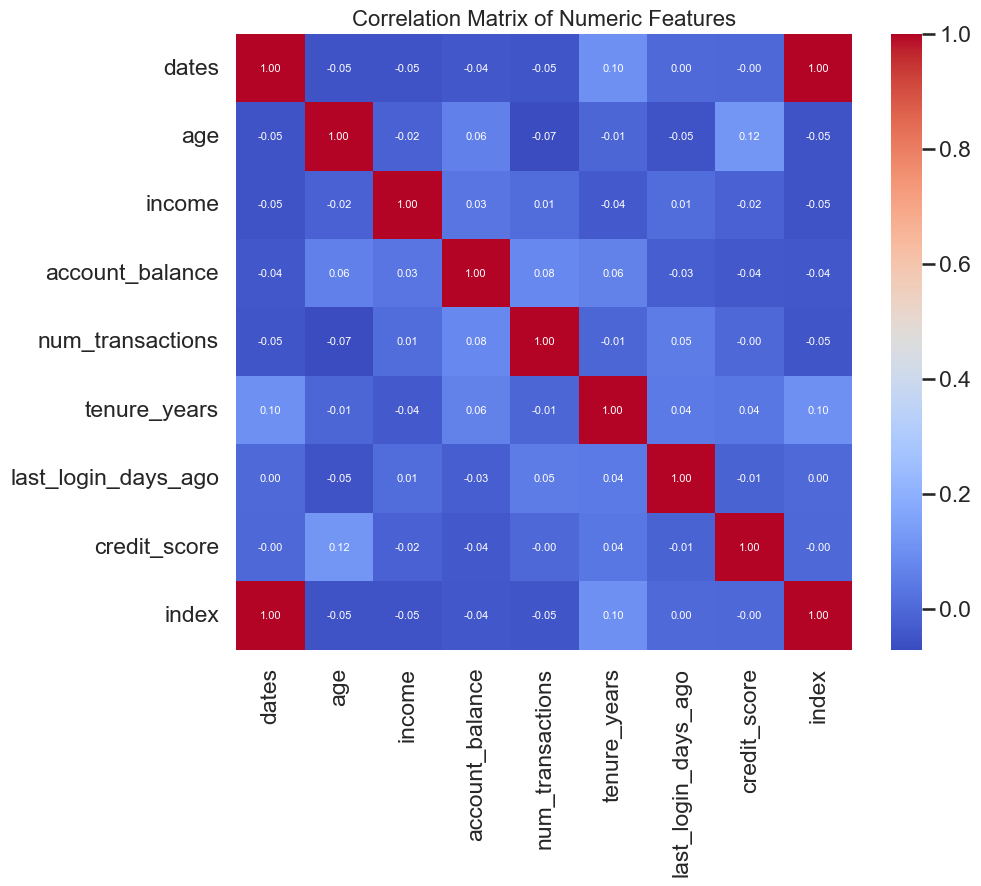

dates       age    income  account_balance  \
dates                1.000000 -0.050329 -0.053289        -0.043541   
age                 -0.050329  1.000000 -0.016978         0.059915   
income              -0.053289 -0.016978  1.000000         0.032054   
account_balance     -0.043541  0.059915  0.032054         1.000000   
num_transactions    -0.046151 -0.071087  0.011877         0.079920   
tenure_years         0.104148 -0.006989 -0.035257         0.063037   
last_login_days_ago  0.001033 -0.051723  0.012576        -0.028660   
credit_score        -0.002117  0.118632 -0.020621        -0.040701   
index                1.000000 -0.050329 -0.053289        -0.043541   

                     num_transactions  tenure_years  last_login_days_ago  \
dates                       -0.046151      0.104148             0.001033   
age                         -0.071087     -0.006989            -0.051723   
income                       0.011877     -0.035257             0.012576   
account_balance              0.079920      0.063037            -0.028660   
num_transactions             1.000000     -0.005742             0.046682   
tenure_years                -0.005742      1.000000             0.044492   
last_login_days_ago          0.046682      0.044492             1.000000   
credit_score                -0.000794      0.036169            -0.014053   
index                       -0.046151      0.104148             0.001033   

                     credit_score     index  
dates                   -0.002117  1.000000  
age                      0.118632 -0.050329  
income                  -0.020621 -0.053289  
account_balance         -0.040701 -0.043541  
num_transactions        -0.000794 -0.046151  
tenure_years             0.036169  0.104148  
last_login_days_ago     -0.014053  0.001033  
credit_score             1.000000 -0.002117  
index                   -0.002117  1.000000

In [72]:
# Correlation Matrix
plt.figure(figsize=(10,8))
# ignore savings
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
corr = df.drop(columns=['customer_id', 'account_type', 'region', 'churned', 'default_flag']).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, annot_kws={"size":8})
plt.show()  
corr

## 8. Reusable Helper: `eda_summary(df)`

In [73]:
def eda_summary(df: pd.DataFrame, numeric_cols=None):
    """Return a dict with quick profiling stats and basic missingness.
    numeric_cols: optional list to limit numeric profiling.
    """
    if numeric_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    out = {}
    out['shape'] = df.shape
    out['dtypes'] = df.dtypes.to_dict()
    out['missing'] = df.isna().sum().to_dict()
    profile = df[numeric_cols].describe().T
    profile['skew'] = [skew(df[c].dropna()) for c in profile.index]
    profile['kurtosis'] = [kurtosis(df[c].dropna()) for c in profile.index]
    out['numeric_profile'] = profile
    return out

summary = eda_summary(df)
summary['shape'], list(summary['dtypes'].items())[:3]

((360, 14),
 [('dates', dtype('<M8[ns]')),
  ('customer_id', dtype('int64')),
  ('age', dtype('int64'))])

## 9. “So What?”: Insights & Assumptions for the data above
- **Skew**: `income` and `spend` are right-skewed → consider log transforms for linear models.  
- **Outliers**: `transactions` show spikes → verify data quality; maybe winsorize.  
- **Relationships**: positive `income–spend`; check nonlinearity (might motivate interaction terms later).  
- **Missingness**: imputation strategy required before modeling.  



## 10. “So What?”: Insights & Assumptions

| Insight / Finding             | Assumption                                                                 | Example Actions / Next Steps                                                                 |
|-------------------------------|----------------------------------------------------------------------------|----------------------------------------------------------------------------------------------|
| **Missing values**            | Some entries in **income**, **credit_score**, or **transactions** might be missing at random or systematically. | Impute (mean/median/mode), forward-fill, or drop rows/columns; optionally flag missingness as a feature. |
| **Skewed distribution**       | Variables like **income** and **transactions** are right-skewed.           | Apply log-transform or other normalization if needed for modeling.                          |
| **Outliers**                  | Extreme values in **transactions** or **income** may be rare events or errors. | Cap/winsorize, remove, or leave if using robust models.                                     |
| **Correlation between columns** | Strong correlation between **income** and **credit_score**, also age vs. income, might indicate redundancy. | Consider dropping one column, applying Principal Component Analysis, or using regularized models.                    |
| **Trends / time patterns**    | **Transactions** or **spending** may show weekly/monthly/yearly seasonality. | Aggregate by time period, create lagged or rolling features for forecasting or modeling.     |
| **Relationships between variables** | **Income vs. transactions** relationships may reveal interactions.        | Consider interaction terms, polynomial features, or segmented models.                       |
| **Feature engineering opportunities** | Derived features (e.g., **savings-to-income ratio**, rolling averages) can capture additional signal. | Create ratios, differences, rolling averages, or binary thresholds.                         |
| **Data quality / anomalies**  | Unusual patterns in **credit_score** or **transactions** may indicate entry errors. | Verify with domain knowledge and clean or remove if necessary.                              |
